# Setup

In [1]:
!nvidia-smi
# if you see K80 change the runtime until you see P4.

Thu Jul  9 00:04:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
print(device_name)

if device_name != b'Tesla K80':
    print('Woo! You got the right kind of GPU!', device_name)
else:
  raise Exception("""
    Unfortunately this instance does not have a T4 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)  

b'Tesla T4'
Woo! You got the right kind of GPU! b'Tesla T4'


In [3]:
# cuda version
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
# python version
!python -V; pip -V

Python 3.6.9
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


# Install cuda
- https://news.developer.nvidia.com/run-rapids-on-google-colab/

In [ ]:
%%time

# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

# Load data using io.StringIO and cudf

In [7]:
import nvstrings, nvcategory, cudf
import io, requests,sys

# read data directly to memory
# github readme: https://github.com/rapidsai/cudf
url = "https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

In [9]:
sys.getsizeof(content)

7992

In [11]:
gdf = cudf.read_csv(io.StringIO(content))

In [12]:
sys.getsizeof(gdf)

13761

In [13]:
# # read data using seaborn

import seaborn as sns

pdf = sns.load_dataset('tips')
sys.getsizeof(pdf)

# # create gpu dataframe
# gdf = cudf.DataFrame(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


7993

In [14]:
gdf['tip_percentage'] = gdf['tip']/gdf['total_bill']*100

# display average tip by dining party size
print(gdf.groupby('size')['tip_percentage'].mean())

size
1    21.729202
2    16.571919
3    15.215685
4    14.594901
5    14.149549
6    15.622920
Name: tip_percentage, dtype: float64


In [16]:
gdf.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


# Data Preprocessing

In [18]:
import cudf

In [22]:
gdf = cudf.get_dummies(gdf,columns=['sex','smoker','day','time'])
gdf.head(2)

,total_bill,tip,size,tip_percentage,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2,5.944673,1,0,1,0,0,0,1,0,1,0
1,10.34,1.66,3,16.054159,0,1,1,0,0,0,1,0,1,0


In [23]:
gdf = gdf.drop('tip_percentage',axis=1)
gdf.head(2)

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2,1,0,1,0,0,0,1,0,1,0
1,10.34,1.66,3,0,1,1,0,0,0,1,0,1,0


# Train test split

In [37]:
import cuml
SEED = 100
target = 'tip'

X_train,X_test, y_train, y_test = cuml.train_test_split(gdf.drop(target,axis=1),
        gdf[[target]],test_size=0.2,random_state=SEED)

gdf.shape, X_train.shape, y_train.shape

((244, 13), (196, 12), (196, 1))

In [38]:
X_train, X_valid,y_train, y_valid = cuml.train_test_split(X_train,y_train,
                                        test_size=0.2,random_state=SEED)

X_train.shape, X_valid.shape

((157, 12), (39, 12))

In [40]:
y_train.head(2)

,tip
107,4.29
232,3.39


# Data matrix for xgboost

In [54]:
import xgboost as xgb
print('XGBoost Version:', xgb.__version__)

XGBoost Version: 1.1.0


In [74]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dvalid = xgb.DMatrix(X_valid,label=y_valid)
dtest = xgb.DMatrix(X_test)

del X_train
del X_valid
del X_test

In [47]:
sys.getsizeof(X_train), sys.getsizeof(dtrain)

(4146, 56)

# Xgboost parameters
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [51]:
# instantiate params
params = {}
classification = False

# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1  # change this to -1 to use all GPUs available or 0 to use the CPU
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist' 
params.update(booster_params)

# learning task params
learning_task_params = {}
if classification:
    learning_task_params['eval_metric'] = 'auc'
    learning_task_params['objective'] = 'binary:logistic'
else:
    learning_task_params['eval_metric'] = 'rmse'
    learning_task_params['objective'] = 'reg:squarederror'
params.update(learning_task_params)
print(params)

{'silent': 1, 'tree_method': 'gpu_hist', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'}


# Xgboost modelling using DMatrix

In [48]:
# model training settings
evallist = [(dvalid, 'valid'), (dtrain, 'train')]
num_round = 100

In [ ]:
%%time

bst = xgb.train(params, dtrain, num_round, evallist)

# Model Evaluation

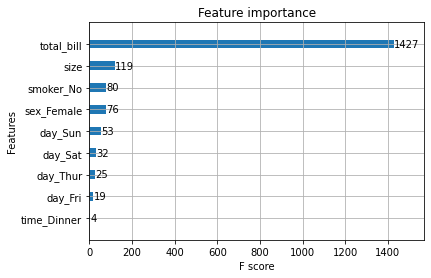

In [69]:
xgb.plot_importance(bst,height=0.4)